## Mapping the tweets and other visualizations
Finally, we have integrated our geocodes and sentiments. In this notebook, we showcase various way of mapping the tweets over the municipalities of the Netherlands. Other methods of visualization are also included when these reflect the nature of the data better. All geo-operations and visualizations were done with geopandas, while other visualizations are done using Seaborn. 

In [2]:
# Import needed modules
import geopandas  as gpd
import numpy as np
import pandas as pd
import cbsodata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from shapely.geometry import Point, Polygon
import itertools

# Read data that was generated from the previous script
df = pd.read_csv('tweets_with_location.csv')

### Pre-processing
Before we can map the tweets, we need to subset the tweets that actually have a valid location within the Netherlands. We do this using spatial municipality data from [cbs](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=70072ned&_theme=235) and with the help from their [tutorial](https://www.cbs.nl/nl-nl/onze-diensten/open-data/statline-als-open-data/cartografie).

In [3]:
# Drop the columns with empty latitude cells
df.dropna(subset=['lat'], inplace = True)
df.shape
# 6281 tweets remain

# Convert to Geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

EPSG:4326
epsg:28992


(-176.0052402686374, 126.3808914413859, -10.871540185, 68.21208608500001)

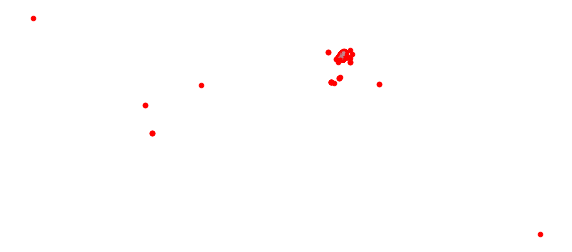

In [4]:
# Downloading municipality geodataframe and population data
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))
population_data = pd.DataFrame(cbsodata.get_data('83765NED', select = ['WijkenEnBuurten', 'Codering_3', 
                                                                       'AantalInwoners_5','Bevolkingsdichtheid_33']))

population_data['Codering_3'] = population_data['Codering_3'].str.strip()

# Call the municipalities from url
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
geodata_gemeentegrenzen = gpd.read_file(geodata_url)

# Merge the population and municipality data
gemeentegrenzen = pd.merge(geodata_gemeentegrenzen, population_data,
                           left_on = "statcode", 
                           right_on = "Codering_3")

# Check crs
print(gdf.crs)
print(gemeentegrenzen.crs)

# Set gemeentegrenzen from RD New to WGS
gemeentegrenzen = gemeentegrenzen.to_crs("EPSG:4326")

# Check the data by plotting
point_plot = gdf.plot(color = 'red',
               zorder = 1,
               markersize = 20,
               figsize = (10,8))
gemeentegrenzen.plot(ax = point_plot, color = 'lightblue', zorder = 2)
point_plot.axis('off')


#### Setting extent and clipping
Hmmm... It seems that some points are still located (far) outside of the Netherlands. To keep our data tidy, we clip these locations from the dataset, using the bounding box of the municipalities.

In [5]:
# Create boundary box to clip
bbox = gemeentegrenzen.total_bounds
p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

# Get coordinates of the boundary 
np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

# Create polygon 
bb_polygon = Polygon([np1, np2, np3, np4])

# Create dataframe with polygon in WGS
df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'], crs="EPSG:4326")

# Clip tweets that are outside the Dutch bbox
clipped_tweets = gpd.clip(gdf, df2)
clipped_tweets.shape
# 6230 tweets remain

(6230, 27)

### Visualization
#### Mapping the number of tweets
First, we want to get an overview of the municipalities where people tweet frequently. We do this by mapping the absolute number of tweets, and then adjusting for population.

#### Absolute number of tweets

Text(0.5, 1.0, 'Tweet Count')

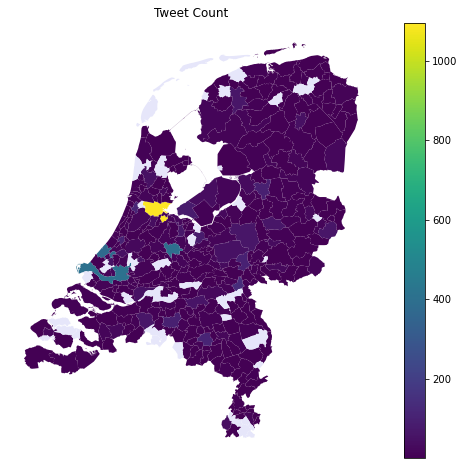

In [6]:
# Add count of tweets per municipality
tweets_joined = gpd.sjoin(gemeentegrenzen, clipped_tweets)
tweets_joined['tweet_count'] = 1
tweets_per_munic = tweets_joined.groupby('statnaam')['tweet_count'].sum()
gemeentegrenzen_tweets = gemeentegrenzen.merge(right = tweets_per_munic, how='left', left_on = 'statnaam', right_index=True)

# Plot the tweet count per municipality
p = gemeentegrenzen_tweets.plot(column='tweet_count',
                                figsize = (10,8),
                                legend = True,
                                cmap = 'viridis',
                                linewidth = 0.1,
                                missing_kwds={"color": "lavender",
                                       "label": "Missing values"}
                         )
p.axis('off')
p.set_title('Tweet Count')

<ipython-input-7-fa214dee58c3>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gemeentegrenzen_tweets_points['geometry'] = gemeentegrenzen_tweets['geometry'].centroid


(3.1649473232479832, 7.420426366177794, 50.61015985004899, 53.69485788392123)

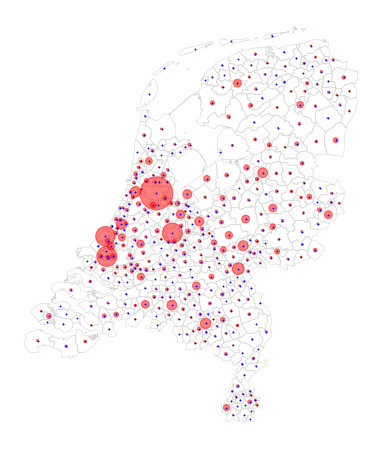

In [7]:
# Perhaps a nicer way of visualizing
# Plot as points with density cluster (ignore warning)
gemeentegrenzen_tweets_points = gemeentegrenzen_tweets.copy()
gemeentegrenzen_tweets_points['geometry'] = gemeentegrenzen_tweets['geometry'].centroid

p = gemeentegrenzen_tweets_points.plot(color = 'blue',
                                       zorder = 3,
                                       marker = '*',
                                       markersize = 1,
                                       figsize = (10,8))
gemeentegrenzen_tweets_points.plot(ax = p, markersize = gemeentegrenzen_tweets_points['tweet_count'], color = 'red', zorder = 2, alpha = 0.5)
gemeentegrenzen_tweets.boundary.plot(ax = p, color = 'lightgrey', zorder = 1, linewidth=0.5)
p.axis('off')


#### Normalized number of tweets

Text(0.5, 1.0, 'Tweets per capita')

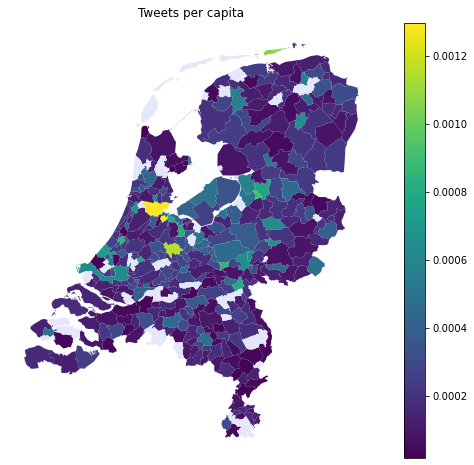

In [8]:
# Normalize for population
gemeentegrenzen_tweets['tweets_per_capita'] = gemeentegrenzen_tweets['tweet_count']/gemeentegrenzen_tweets['AantalInwoners_5']

p = gemeentegrenzen_tweets.plot(column='tweets_per_capita', 
                         figsize = (10,8),
                         legend = True,
                         cmap = 'viridis',
                         linewidth = 0.1,
                         missing_kwds={"color": "lavender",
                                       "label": "Missing values"}
                         )
p.axis('off')
p.set_title('Tweets per capita')

Apparently, large cities stand out in terms of active tweeters, even after normalizing for the population. This points towards the bias in Twitter data towards urban populations, and other associated socio-economic characteristics of city-dwellers, such as age, income and education.   
 
 


#### Mapping sentiment
Next, we map the average sentiment scores of the tweets gathered per municipality. Note that some municipalities have a very limited number of tweets. Therefore, the average score is defined by a small number of tweets and is not representative of that municipality. In our storymap, the number of tweets can be examined in an interactive map.

Text(0.5, 1.0, 'Average sentiment')

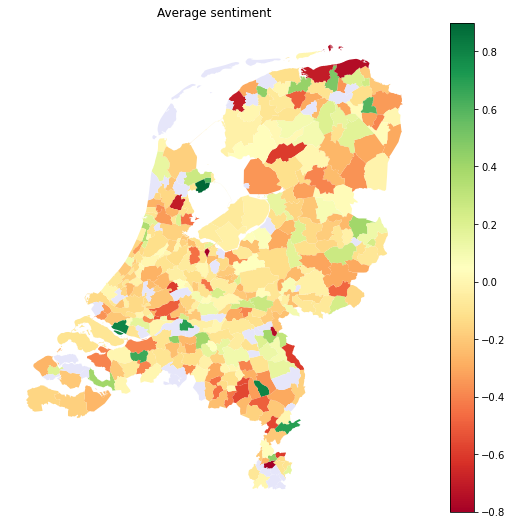

In [15]:
# Add average sentiment scores so it can be plotted
sent_per_munic = tweets_joined.groupby('statnaam')['google'].mean()
gemeentegrenzen_tweets = gemeentegrenzen_tweets.merge(right = sent_per_munic, how='left', left_on = 'statnaam', right_index=True)

# Plot the average sentiment 
p = gemeentegrenzen_tweets.plot(column='google', 
                         figsize = (10,9),
                         cmap = 'RdYlGn',
                         legend = True,
                         linewidth = 0.1,
                         missing_kwds={"color": "lavender",
                                       "label": "Missing values"}
                         )
                         
p.axis('off')
p.set_title('Average sentiment')


#### Creating an 'election results' map
There doesn't seem to be a recognizable pattern in the sentiment map. This is due to the limited amount of tweets that remain per municipality, and the limited accuracy of sentiment analysis. In addition, it is doubtable if a spatial pattern would emerge, even with perfect information.
Perhaps we can yield better results by plotting the municipalities with their 'most-mentioned' party?

vvd             111
d66             104
cda              75
fvd              50
groenlinks       35
pvda             35
pvv              31
volt             22
sgp              15
pvdd             12
bbb              11
bij1             10
 sp              10
christenunie      9
 denk             6
50plus            4
ja21              4
Name: party, dtype: int64

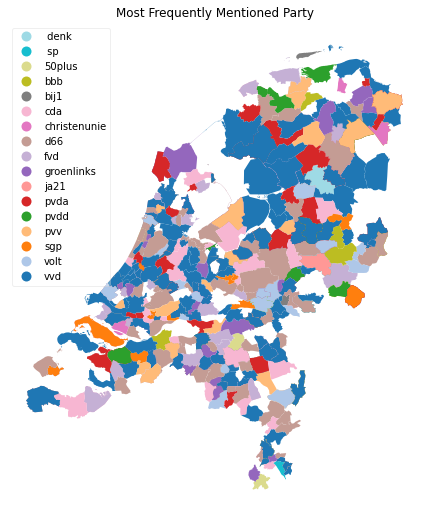

In [13]:
# Voters map
# Add count of tweets per municipality
tweets_joined = gpd.sjoin(gemeentegrenzen, clipped_tweets)
munic_mode_party = tweets_joined.groupby('statnaam')['party'].apply(pd.Series.mode) #.agg(pd.Series.mode)
munic_mode_party_df = munic_mode_party.to_frame() 

# Drop parties that are tied in number of mentions and are stored as a list
munic_mode_party_df['party_2'] = munic_mode_party_df['party'].apply((lambda x: isinstance(x, str)))
munic_moode_party_df_2 = munic_mode_party_df[munic_mode_party_df['party_2']==True]

# Merge to municipality gdf
gemeente_mode = gemeentegrenzen.set_index('statnaam')
gemeente_mode = pd.merge(gemeente_mode, munic_moode_party_df_2, right_index=True, left_index = True)

# Plot the winning party (the missing municipalities are tied)
p = gemeente_mode.plot(column='party',
                       figsize = (10,9),
                       legend = True,
                       legend_kwds={'loc': 'upper left', 'framealpha':0.3},
                       linewidth = 0.1,
                       cmap = 'tab20_r')
p.axis('off')
p.set_title('Most Frequently Mentioned Party')

# Check the count of how many times each party it the most popular in a municipality
munic_moode_party_df_2['party'].value_counts()

Still no recognizable patterns visible... In addition, there are a lot of missing municipalities due to 'ties' in party scores (which is in turn due to the limited number of tweets). When we compare it to the actual election outcome, we see there doesn't seem to be a relation between them, except perhaps for the general prominence of the two winning parties, VVD and D66:

<div>
<img src="Real_NL.png" width="400">
</div>

#### Cluster analysis
To assess if any recognizable clusters can be identified, a cluster analysis was applied to the number of tweets per capita to see if any other patterns (apart from the large-city-pattern) can be identified.

Text(0.5, 1.0, 'Clusters in tweets per capita')

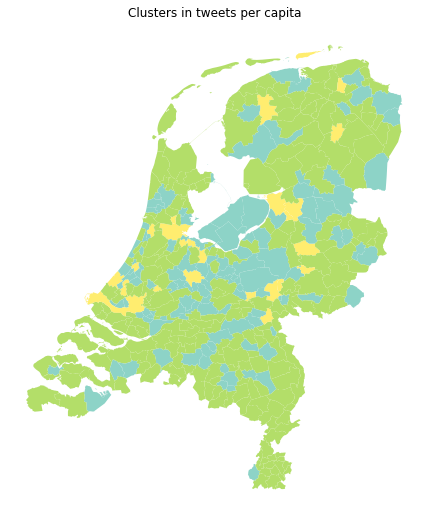

In [19]:
# Store data in a new variable
data = gemeentegrenzen_tweets

# Replace Nan with 0
data['tweets_per_capita'].fillna(0, inplace=True)

# Choose variable to cluster on
data_clustervars = data[['tweets_per_capita']]

# Determine clustering method and number of clusters
kmeans = KMeans(n_clusters=3, max_iter=1000,n_init=150).fit(data_clustervars)
centroids = kmeans.cluster_centers_
data['cluster'] = kmeans.labels_

# Store geometry
geometry = gemeentegrenzen.geometry

# Merge cluster numbers to gemeentegrenzen
gemeenten_clusters = gemeentegrenzen.merge(data,left_on = "statcode", right_on = "statcode")

# Merging erases the geometry, so we have to re-install it
gemeenten_clusters = gpd.GeoDataFrame(gemeenten_clusters, geometry=geometry, crs="EPSG:4326")

# Maka a themetic map (run as block)
p = gemeenten_clusters.plot(column='cluster',
                            figsize = (10,9),
                            cmap = 'Set3')
p.axis('off')
p.set_title('Clusters in tweets per capita')


When we set the number of clusters to 3 (which is quite low), we see a pattern we recognize from before: The larger cities are grouped together. We also see an additional pattern with the blue areas, which are municipalities with a moderate amount of tweets. This is also reflected in the maps produced earlier (normalized amount of tweets). Lastly, the green areas indicate the areas with a very low percentage of active tweeters. Overall, we can see a general trend of more active tweeters in urban and semi-urban areas, and the least active tweeters in rural areas

#### Mentions of parties in the three largest cities
It seems that there are little results of interest when plotting party counts spatially, as the number of tweets is in many municipalities simply too low. Perhaps if we only focussed on the cities with a large amount of tweets, the outcomes will be more representative? Since mapping is not an attractive option for this, we will plot this using piecharts.

<ipython-input-21-74011343b092>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city.dropna(subset=['party'], inplace = True)


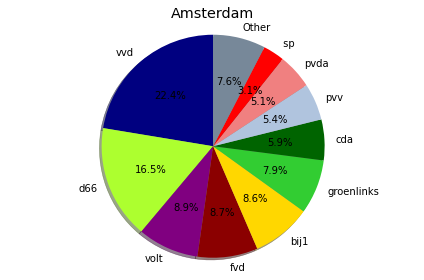

<ipython-input-21-74011343b092>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city.dropna(subset=['party'], inplace = True)


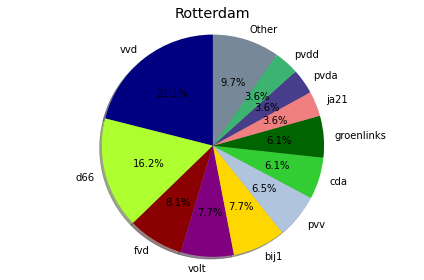

<ipython-input-21-74011343b092>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city.dropna(subset=['party'], inplace = True)


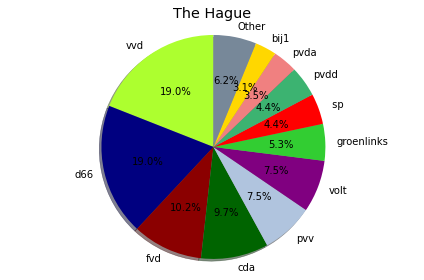

In [21]:
# Function that subsets data from a city and creates a dictionary
def party_mentions(cityname, colors, title):
    city = clipped_tweets[clipped_tweets['location'] == cityname]
    city.dropna(subset=['party'], inplace = True)
    party_count = city['party'].value_counts()
    party_norm = (party_count/city.shape[0])*100
    party_norm = party_norm.to_dict()
    make_piechart(party_norm, colors, title)

# Function that groups parties together if they have less than 3% of the mentions and creates a pie chart
def make_piechart(party_norm, colors, title):
    plt.style.use('ggplot')
    dic = party_norm
    # Group together all elements in the dictionary whose value is less than 3
    # Name this group 'All the rest'
    newdic={}
    for key, group in itertools.groupby(dic, lambda k: 'Other' if (dic[k]<3) else k):
        newdic[key] = sum([dic[k] for k in list(group)])   

    labels = newdic.keys()
    sizes = newdic.values()
    colors = colors
    fig, ax = plt.subplots()

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
           colors = colors, shadow = True)
    plt.title(title)
    ax.axis('equal')
    plt.tight_layout()

    plt.show()

party_mentions('amsterdam', ['navy', 'greenyellow',
                             'purple', 'darkred','gold',
                             'limegreen', 'darkgreen',
                             'lightsteelblue','lightcoral',
                             'red', 'lightslategrey'],
              'Amsterdam')
party_mentions('rotterdam', ['navy', 'greenyellow',
                             'darkred', 'purple', 'gold',
                             'lightsteelblue', 'limegreen',
                             'darkgreen', 'lightcoral',
                             'darkslateblue', 'mediumseagreen',
                             'lightslategrey'],
              'Rotterdam')
party_mentions('\'s-gravenhage', ['greenyellow', 'navy',
                                  'darkred', 'darkgreen',
                                  'lightsteelblue', 'purple',
                                  'limegreen', 'red',
                                  'mediumseagreen', 'lightcoral',
                                  'gold', 'lightslategrey'],
              'The Hague')

When we compare this to the actual outcomes in those cities, the piecharts slightly reflect the actual outcomes, especially the larger (VVD and D66) and smaller (PvdA, PvDD) parties. However, it is clear that some parties are very under-represented in the tweets when compared to reality, especially PVV, Denk and GroenLinks
  
                Amsterdam                               Rotterdam                                 The Hague

<table><tr>
<td> <img src="Real_Ams.png" alt="Amsterdam" style="width: 400px;"/> </td>
<td> <img src="Real_Rot.png" alt="Rotterdam" style="width: 400px;"/> </td>
<td> <img src="Real_Hag.png" alt="The Hague" style="width: 400px;"/> </td>
</tr></table>

#### Violin plots of sentiment distribution per party
Lastly, we want to explore the sentiments of the tweets a little further by parsing them out for party mentions. We do this by plotting the distribution of sentiments for tweet sets that are tagged with a specific party in our previous notebooks. 

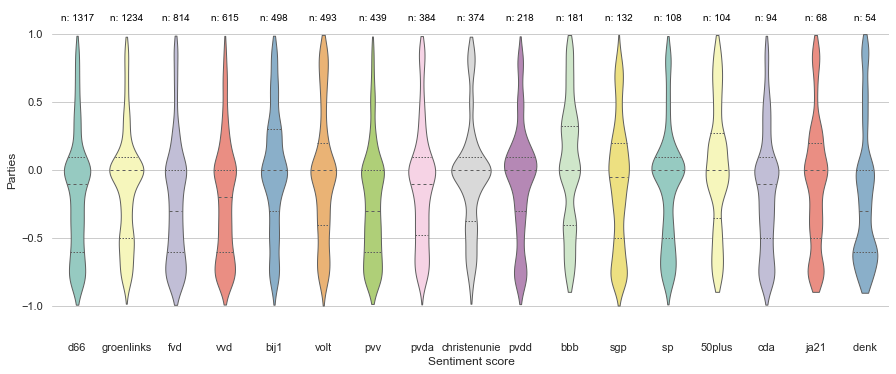

In [22]:
# create violin plots of party sentiments
violin_df = pd.read_csv('tweets_with_location.csv') 

sns.set_theme(style="whitegrid")

#Create variables that indicate the place of the labels (bit clumsy)
medians = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
nobs = violin_df['party'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Plot the violins
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.violinplot(x="party", y="google", data=violin_df, 
                    palette = 'Set3', bw=.2, cut=1, linewidth=1,# Colors : flare/viridis/crest_r/light:g_r/Set3
                    inner = 'quartile') # or None or box or stick or point or quartile
ax.set(ylim=(-1.2, 1.2))
ax.set_ylabel("Parties")
ax.set_xlabel("Sentiment score")
sns.despine(left=True, bottom=True)
# Add labels with number of observations
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick]+1.1,nobs[tick],
            horizontalalignment = 'center',
            size = 'small',
            color = 'black',
            weight = 'roman')


This plot shows the sentiment distribution per party among the tweets. Note that for the party on the right side of the plot, the n is very low, and thus does not provide a representitive image. In this plot we can see an interesting trend that could underline the left-wing bias among tweeters. The dotted line in the middle of the 'violins' indicate the mean of the distribution. We see that, in general, the mean of left-wing parties (GroenLinks, Bij1, PvdA, PvdD, SP) is centered around the mean, which means the sentiments all average out around 'neutral' (with the exception of PvdA). In addition, we see that right-wing parties (FvD, VVD, PVV, SGP, CDA) score more negatively on average. Centrist parties (D66, Volt, Christenunie) score negative and neutral respectively.
This could indicate that, on average, tweets that mention right-wing parties are more likely to be negative than left-wing parties. For centrist parties it is less easy to spot a trend. However, this is just a visual interpretation, and more rigorous testing and data collection should be applied before making any hard statements.

#### Reflection
After all the cleaning and geocoding procedures, there was only a limited amount of tweets left. Therefore we were not able to create all visualizations that we initially wanted to (such as parsing and mapping geo-tweets per parties), because the amount of tweets per municipality was simply too low. In this notebook, only the visualizations are included that we deemed relatively representable in terms of observations.
However, the number of tweets is still quite limited, as is also shown above. Because of this, our research is less representative and usefull than if we would have used more tweets. If there was time to do things differently, we would definitely try to harvest more tweets than we did now. If possible, it would be wise to gather at least 10 times more tweets (500 000) than in this project.